In [33]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def run_model(T,S, C, p, e, d):
    model = gp.Model('AmazonLockerOptimization_Extended')

    # Decision Variables

    # x = the number of slots to reserve for shipoption s on day t
    x = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="x")
    
    # y = the number of packages accepted for arrival for ship options s on day t
    y = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="y")

    # Objective Function (A.1)
    model.setObjective(gp.quicksum(y[s, t] for s in range(S) for t in range(T)), GRB.MAXIMIZE)

    # Constraint (A.2): Ensure locker capacity is not violated
    for t in range(T):
        model.addConstr(
            gp.quicksum(p[s][v][t] * y[s, v] for s in range(S) for v in range(t+1)) +
            gp.quicksum(p[s][v][t] * e[s][v] for s in range(S) for v in range(-6, 1)) <= C
        )

    # for t in range(T):
    #     model.addConstr(
    #         gp.quicksum(p[s][v][t] * y[s, v] for s in range(S) for v in range(max(t - 76, 0), t + 1)) +
    #         gp.quicksum(p[s][v][t] * e[s][v] for s in range(S) for v in range(max(t - 76, 0), t + 1)) <= C
    #     )

    # Constraint (A.3): Number of packages accepted must be less than or equal to the demand
    for s in range(S):
        for t in range(T):
            model.addConstr(y[s, t] <= d[s][t])

    # Constraint (A.4): Relationship between number of packages accepted and slots reserved
    for s in range(S):
        for t in range(T):
            model.addConstr(
                gp.quicksum(p[s][v][t] * y[s, v] for v in range(t+1)) +
                gp.quicksum(p[s][v][t] * e[s][v] for v in range(-6, 1)) == x[s, t]
            )

    # Constraint (A.5): Non-negativity of decision variables
    for s in range(S):
        for t in range(T):
            model.addConstr(x[s, t] >= 0)
            model.addConstr(y[s, t] >= 0)

    model.optimize()
    
    return model

# capacities = [119, 125, 150, 175, 200, 250, 275, 300, 325, 350]
# capacities = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 119]
capacities = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, 20]

results = {}

# Generate parameters using distributions
np.random.seed(42)  

# Parameters
T = 77  # Planning horizon (hours)
S = 4  # Number of shipping options (standard, two-day, one-day, same-day)

# Generate random dwell time probabilities
p_standard = [np.clip(np.random.normal(1.1, 0.2, T), 0, None).tolist() for _ in range(-6, T)]
p_two_day = [np.clip(np.random.normal(0.75, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p_one_day = [np.clip(np.random.normal(0.65, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p_same_day = [np.clip(np.random.normal(0.55, 0.1, T), 0, None).tolist() for _ in range(-6, T)]
p = [p_standard, p_two_day, p_one_day, p_same_day]

# Generate random initial packages in locker at the end of day 0
e_standard = np.random.randint(0, 2, size=T).tolist()
e_two_day = np.random.randint(0, 2, size=T).tolist()
e_one_day = np.random.randint(0, 2, size=T).tolist()
e_same_day = np.random.randint(0, 2, size=T).tolist()
e = [e_standard, e_two_day, e_one_day, e_same_day]

# Generate random package demand forecast
ratio_of_standard = 0.33
ratio_of_two_day = 0.264
ratio_of_one_day = 0.142
ratio_of_same_day = 0.264

num_packages_delivered = np.round(30*7/77)
rate_standard = num_packages_delivered*ratio_of_standard  # Average rate for standard shipping
rate_two_day =  num_packages_delivered*ratio_of_two_day # Average rate for two-day shipping
rate_one_day = num_packages_delivered*ratio_of_one_day # Average rate for one-day shipping
rate_same_day = num_packages_delivered*ratio_of_same_day # Average rate for same-day shipping

d_standard = np.random.poisson(rate_standard, size=T).tolist()
d_two_day = np.random.poisson(rate_two_day, size=T).tolist()
d_one_day = np.random.poisson(rate_one_day, size=T).tolist()
d_same_day = np.random.poisson(rate_same_day, size=T).tolist()
d = [d_standard, d_two_day, d_one_day, d_same_day]
print(d)

throughputs = []
for C in capacities:
    try:
        result = run_model(T, S, C, p, e, d)
        results[C] = result
        throughputs.append(result.ObjVal)
        print(f"Locker capacity: {C}, Objective value: {result.ObjVal}")
    except:
        throughputs.append(0)

[[2, 2, 0, 1, 0, 2, 1, 0, 3, 0, 0, 1, 2, 1, 1, 0, 0, 2, 0, 1, 4, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 3, 1, 1, 0, 3, 2, 0, 0, 2, 1, 1, 1, 0, 3, 0, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 3, 0, 2, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 3, 1, 1], [0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 1, 4, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 4, 3, 0, 1, 1, 0, 4, 1, 4, 0, 1, 1, 2, 1, 2, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [1, 0, 2, 0, 2, 1, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 3, 1, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 1

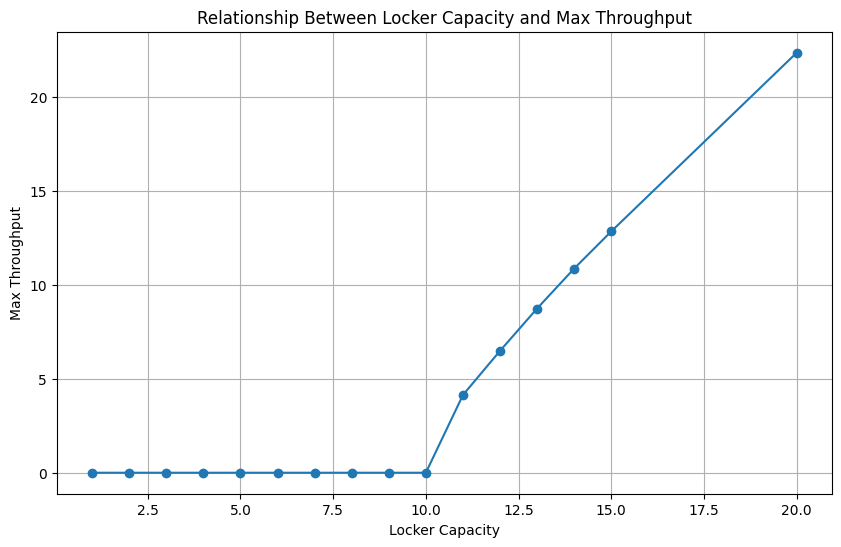

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(capacities, throughputs, marker='o')
plt.xlabel('Locker Capacity')
plt.ylabel('Max Throughput')
plt.title('Relationship Between Locker Capacity and Max Throughput')
plt.grid(True)
plt.show()

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def run_model(T,S, C, p, e, d):
    model = gp.Model('AmazonLockerOptimization_Extended')

    # Decision Variables

    # x = the number of slots to reserve for shipoption s on day t
    x = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="x")
    
    # y = the number of packages accepted for arrival for ship options s on day t
    y = model.addVars(S, T, vtype=GRB.CONTINUOUS, name="y")

    # Objective Function (A.1)
    model.setObjective(gp.quicksum(y[s, t] for s in range(S) for t in range(T)), GRB.MAXIMIZE)

    # Constraint (A.2): Ensure locker capacity is not violated
    for t in range(T):
        model.addConstr(
            gp.quicksum(p[s][v][t] * y[s, v] for s in range(S) for v in range(t+1)) +
            gp.quicksum(p[s][v][t] * e[s][v] for s in range(S) for v in range(-76, 1)) <= C
        )

    # Constraint (A.3): Number of packages accepted must be less than or equal to the demand
    for s in range(S):
        for t in range(T):
            model.addConstr(y[s, t] <= d[s][t])

    # Constraint (A.4): Relationship between number of packages accepted and slots reserved
    for s in range(S):
        for t in range(T):
            model.addConstr(
                gp.quicksum(p[s][v][t] * y[s, v] for v in range(t+1)) +
                gp.quicksum(p[s][v][t] * e[s][v] for v in range(-76, 1)) == x[s, t]
            )

    # Constraint (A.5): Non-negativity of decision variables
    for s in range(S):
        for t in range(T):
            model.addConstr(x[s, t] >= 0)
            model.addConstr(y[s, t] >= 0)

    model.optimize()
    
    return model

capacities = [119, 125, 150, 175, 200, 250, 275, 300, 325, 350]
# capacities = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results = {}

# Generate parameters using distributions
np.random.seed(42)  

# Parameters
T = 77  # Planning horizon (hours)
S = 4  # Number of shipping options (standard, two-day, one-day, same-day)

# Generate random dwell time probabilities
p_standard = [np.clip(np.random.normal(1.1, 0.2, T), 0, None).tolist() for _ in range(-76, T)]
p_two_day = [np.clip(np.random.normal(0.75, 0.1, T), 0, None).tolist() for _ in range(-76, T)]
p_one_day = [np.clip(np.random.normal(0.65, 0.1, T), 0, None).tolist() for _ in range(-76, T)]
p_same_day = [np.clip(np.random.normal(0.55, 0.1, T), 0, None).tolist() for _ in range(-76, T)]
p = [p_standard, p_two_day, p_one_day, p_same_day]

# Generate random initial packages in locker at the end of day 0
e_standard = np.random.randint(0, 2, size=T).tolist()
e_two_day = np.random.randint(0, 2, size=T).tolist()
e_one_day = np.random.randint(0, 2, size=T).tolist()
e_same_day = np.random.randint(0, 2, size=T).tolist()
e = [e_standard, e_two_day, e_one_day, e_same_day]

# Generate random package demand forecast
ratio_of_standard = 0.33
ratio_of_two_day = 0.264
ratio_of_one_day = 0.142
ratio_of_same_day = 0.264

num_packages_delivered = np.round(30*7/77)
rate_standard = num_packages_delivered*ratio_of_standard  # Average rate for standard shipping
rate_two_day =  num_packages_delivered*ratio_of_two_day # Average rate for two-day shipping
rate_one_day = num_packages_delivered*ratio_of_one_day # Average rate for one-day shipping
rate_same_day = num_packages_delivered*ratio_of_same_day # Average rate for same-day shipping

d_standard = np.random.poisson(rate_standard, size=T).tolist()
d_two_day = np.random.poisson(rate_two_day, size=T).tolist()
d_one_day = np.random.poisson(rate_one_day, size=T).tolist()
d_same_day = np.random.poisson(rate_same_day, size=T).tolist()
d = [d_standard, d_two_day, d_one_day, d_same_day]
print(d)

throughputs = []
for C in capacities:
    result = run_model(T, S, C, p, e, d)
    results[C] = result
    throughputs.append(result.ObjVal)
    print(f"Locker capacity: {C}, Objective value: {result.ObjVal}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(capacities, throughputs, marker='o')
plt.xlabel('Locker Capacity')
plt.ylabel('Max Throughput')
plt.title('Relationship Between Locker Capacity and Max Throughput')
plt.grid(True)
plt.show()
